# Brief Introduction

Since Russia invaded Ukraine on 24 February (2 months, 3 weeks and 3 days ago as of 17 May), Ukranians have held fast and inflicted considerable losses upon the Russian Armed Forces. To better understand the dimension of those casualties, both in equipment and personnel, we do a brief Exploratory Data Analysis (EDA) using data provided by https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war furthermore, given the accumulation of personnel losses since the start of the war, we run a model to try and predict future personnel losses of Russian forces under an hypothetical scenario where the war continues on similarly to the past weeks.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
from scipy.stats import pearsonr
import squarify
#ML libraries
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Table of Contents

- [Data Curation](#DataCuration)
- [Data Visualization](#DataVisualization)
    - [Personnel Losses](#a1)
        - [Cumulative and Incremental Personnel Losses](#a11)
        - [POWs](#a12)
    - [Equipment Losses:](#a2)
        - [total](#a21)
        - [Breakdown](#a22)
            - [Air equipment (air)](#a221)
            - [Artillery, AA and Support/Logistic vehicles (land)](#a222)
            - [Armoured Vehicles (land)](#a223)
            - [Naval (sea)](#a224)
            - [Brief Comparison](#a225)
    - [Correlation Matrix](#CM)
- [Estimating Future Personnel Losses](#ML)

# Data Curation <a class="anchor" id="DataCuration"></a>

In [2]:
#reading datasets using data from 17/05/2022
df_equipment=pd.read_csv('russia_losses_equipment.csv')
df_personnel=pd.read_csv('russia_losses_personnel.csv')

In [3]:
#looking at our data
df_equipment.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN


In [4]:
#looking at our data
df_personnel.head()

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200


In [5]:
#The equipment data has missing values we need to treat
#the personnel data has a column with little to no value: 'personnel*'

#changing 'date' type to datetime for our timeseries study
df_equipment['date'] = pd.to_datetime(df_equipment['date'])
df_personnel['date'] = pd.to_datetime(df_equipment['date'])
#fill na (missing values)
df_equipment.fillna(value=0, inplace=True)
df_personnel.fillna(value=0, inplace=True)
#drop personnel* since it adds little value
df_personnel.drop(labels= ['personnel*','day'],axis=1, inplace=True)
#merging the two datasets 
df_losses = df_equipment.merge(df_personnel, how='inner',on='date')

In [6]:
#since we have personnel losses are cumulative, we are adding a column with daily/incremental personnel losses
df_losses['incremental_personnel_loss'] = df_losses['personnel'].diff(periods=1)
#setting day 1
df_losses['incremental_personnel_loss'] = df_losses['incremental_personnel_loss'].replace(df_losses['incremental_personnel_loss'][0],df_losses['personnel'][0])

In [7]:
#We also add a column with weeks since the start of the war which will allow us to explore its evolution on a weekly basis

df_losses['week'] = df_losses['day']//7


In [8]:
#looking at our clean and merged dataset
df_losses.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,...,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,personnel,POW,incremental_personnel_loss,week
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,...,2,0,0.0,0.0,0.0,0.0,2800,0,2800.0,0
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,...,2,0,0.0,0.0,0.0,0.0,4300,0,1500.0,0
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,...,2,0,0.0,0.0,0.0,0.0,4500,0,200.0,0
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,...,2,5,0.0,0.0,0.0,0.0,5300,0,800.0,0
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,...,2,7,0.0,0.0,0.0,0.0,5710,200,410.0,0


# Data Visualization <a class="anchor" id="DataVisualization"></a>

## Personnel Losses <a class="anchor" id="a1"></a>

___Plotting Cumulative and Incremental Personnel Losses <a class="anchor" id="a11"></a>___

Text(0.5, 1.0, 'Cumulative Personnel losses')

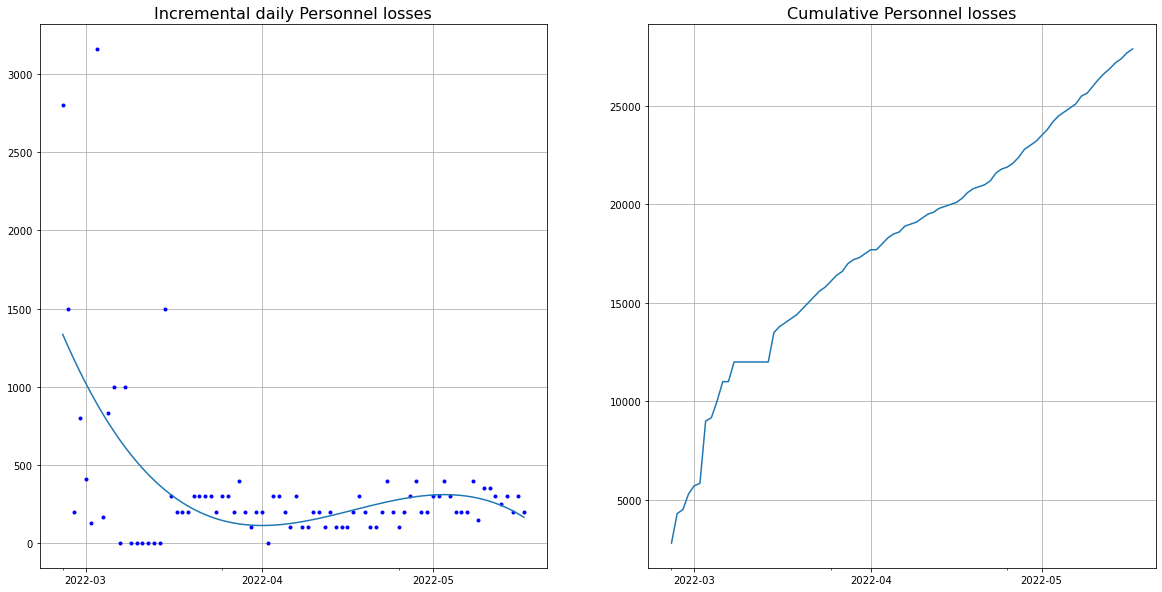

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(df_losses['date'], df_losses['incremental_personnel_loss'], "b.")
axes[1].plot(df_losses['date'], df_losses['personnel'])

for ax in axes:
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[25], interval=1, tz=None))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.grid(True)

    
#adding a trendline to personnel losses
z = np.polyfit(mdates.date2num(df_losses['date']), df_losses['incremental_personnel_loss'], 3)
p = np.poly1d(z)
axes[0].plot(mdates.date2num(df_losses['date']),p(mdates.date2num(df_losses['date'])))

axes[0].set_title('Incremental daily Personnel losses', fontsize = 16)
axes[1].set_title('Cumulative Personnel losses', fontsize = 16)

At first glance, the first days of the war have a considerable variance in daily personnel losses as data did not seem to be frequently updated: Some days report 0 incremental losses while others overcompensate with very high losses. The Incremental daily personnel losses trendline (blue line) indicate casualties tended to decrease until early April, then slightly picked up again.

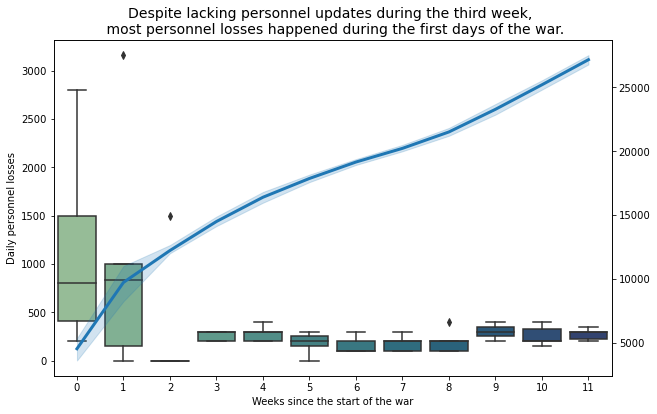

In [10]:
fig,ax1 = plt.subplots(figsize= (10,10*0.618))


bp = sns.boxplot(data = df_losses, 
                     x = "week", 
                     y = "incremental_personnel_loss",
                     palette="crest",
                     ax = ax1)

ax2 = ax1.twinx()

lp = sns.lineplot(data = df_losses, 
                     x = "week", 
                     y = "personnel",
                     linewidth = 3,
                     ax=ax2)
ax1.set(xlabel='Weeks since the start of the war', ylabel='Daily personnel losses')
ax2.set(ylabel='')
ax1.set_title("Despite lacking personnel updates during the third week, \n most personnel losses happened during the first days of the war.", fontsize = 14);

As the title of the box plot suggests, the earliest period of the war involved the most casualties for the invaders. While weeks 5 to 8 suggest lower casualties, from week 9 onwards casualties have been picking up in pace once again.

___Plotting POWs (prisoners-of-war) <a class="anchor" id="a12"></a>___

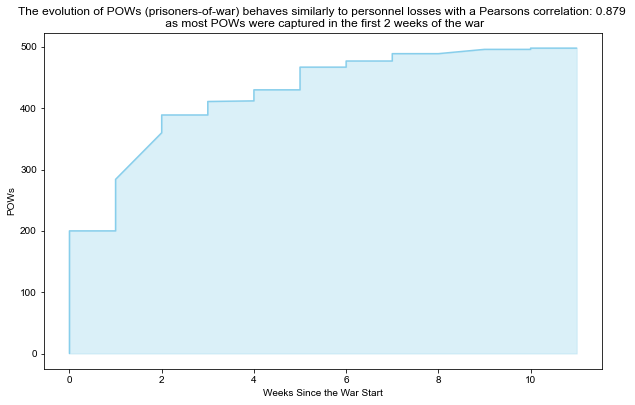

In [11]:
fig,ax = plt.subplots(figsize= (10,10*0.618))

# Change the style of plot
plt.style.use('seaborn-darkgrid')
 
# Make the same graph
ax.fill_between(df_losses["week"], df_losses["POW"], color="skyblue", alpha=0.3)
ax.plot(df_losses["week"], df_losses["POW"], color="skyblue")

#getting correlation with personnel losses
corr, _ = pearsonr(df_losses["POW"], df_losses['personnel'])
Pearsons_correlation = 'Pearsons correlation: %.3f' % corr

# Add titles
plt.title(f"The evolution of POWs (prisoners-of-war) behaves similarly to personnel losses with a {Pearsons_correlation} \n as most POWs were captured in the first 2 weeks of the war", fontsize=12)
plt.xlabel("Weeks Since the War Start")
plt.ylabel("POWs")

# Show the graph
plt.show()

## Equipment Losses <a class="anchor" id="a2"></a>

#### Total <a class="anchor" id="a21"></a>

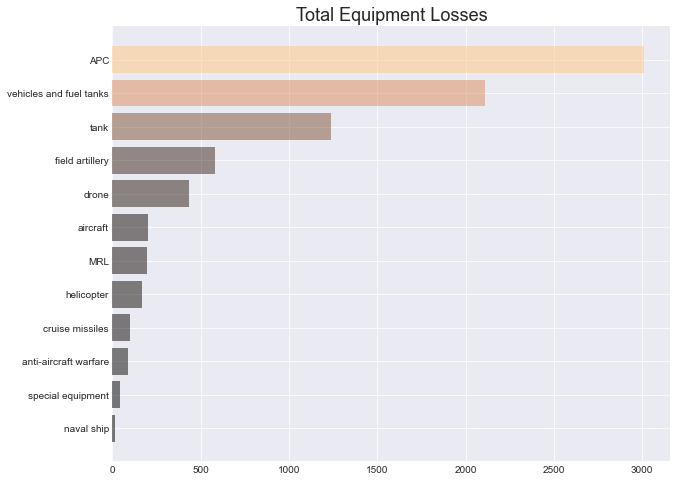

In [12]:
fig,ax = plt.subplots(figsize= (10,8))

#getting the proper df with columns sorted by the last row, we also drop the columnds that were merged into "vehicles and fuel tanks"
df_bar = df_losses.loc[:, ~df_losses.columns.isin(['date', 'day', 'week', 'personnel', 'POW', 'incremental_personnel_loss','military auto', 'fuel tank', 'mobile SRBM system'])].sort_values(by=len(df_losses.index)-1, axis=1)

#It's important to properly capture the data we want before plotting
x = df_bar.columns.values
#we want an array and not index, also we removed irrelevant columns
y = df_bar.tail(1).squeeze().values
#we get the values of the last day to give us the most recent losses

#adding a color map
my_cmap = plt.get_cmap("copper")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

#plotting
ax.barh(x, y, align = 'center', alpha=0.5, color = my_cmap(rescale(y)))
ax.set_title('Total Equipment Losses', fontsize=18)

plt.show()

As seen by the graph above, there are different genres (land, air and sea) of equipment. The diverse nature and end of the Equipments above also implies their loss numbers are very different.
APCs, vehicles & fuel tanks, and tanks are by far the most loss types of Equipment.
To see the evolution of each type of equipment losses, we'll do a breakdown of the different genres of equipment.

#### Breakdown <a class="anchor" id="a22"></a>

___Plotting Air equipment (air) <a class="anchor" id="a221"></a>___

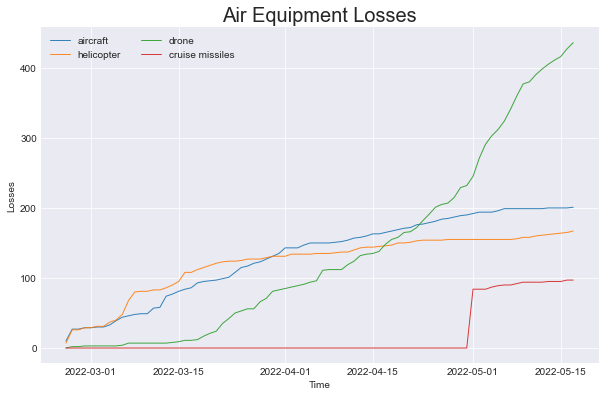

In [13]:
# Plot multiple lines
fig, ax = plt.subplots(figsize= (10,10*0.618))

num=0
for column in df_losses[['aircraft', 'helicopter', 'drone','cruise missiles']]:
    num+=1
    plt.plot(df_losses['date'], df_losses[column], marker='', linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Air Equipment Losses", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Losses")

# Show the graph
plt.show()

While aircraft losses are fairly stable overtime, the first month of the war had proportionally bigger losses of helicopters and less of drones than from the second month onwards. In May we see drone losses escalating massively while little losses of other air equipment are reported.
Note: May incorporates cruise missile losses for the first time since the start of the war.

___Plotting Artillery, AA and Support/Logistic vehicles (land) <a class="anchor" id="a222"></a>___

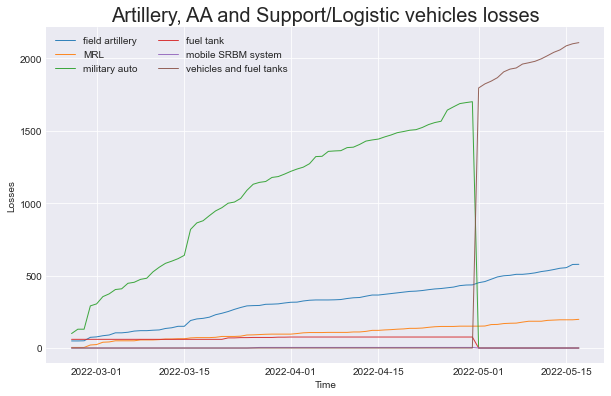

In [14]:
# Plot multiple lines
fig, ax = plt.subplots(figsize= (10,10*0.618))

num=0
for column in df_losses[['field artillery', 'MRL', 'military auto', 'fuel tank','mobile SRBM system', 'vehicles and fuel tanks']]:
    num+=1
    plt.plot(df_losses['date'], df_losses[column], marker='', linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Artillery, AA and Support/Logistic vehicles losses", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Losses")

# Show the graph
plt.show()

By far the most lost equipment under this section is military auto. Field Artillery and MRL losses grow steadily overtime, fuel tank losses happened mostly in the first days of the war, and mobile SRBM system losses seem residual.
Important note: Our source merges 'military auto', 'fuel tank' and 'mobile SRBM system' losses to 'Vehicles and Fuel Tanks' at the end of April, hence the break in the data.

___Plotting Armoured Vehicles (land) <a class="anchor" id="a223"></a>___

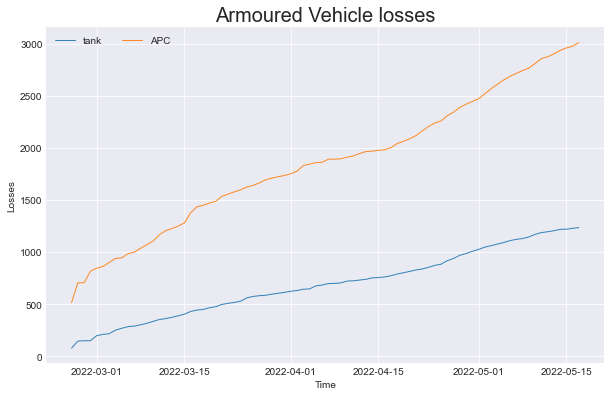

In [15]:
# Plot multiple lines
fig, ax = plt.subplots(figsize= (10,10*0.618))

num=0
for column in df_losses[['tank', 'APC']]:
    num+=1
    plt.plot(df_losses['date'], df_losses[column], marker='', linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Armoured Vehicle losses", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Losses")

# Show the graph
plt.show()

Regarding armoured vehicles, both tanks and APC seem to be getting destroyed at a fairly stable rate throughout all the war, as seen by the slope of the lines, one could argue the rate at which russians are losing armoured vehicles has risen since mid-April.
Note: In comparison to the other section of land equipment APC losses surpassed Military Auto Losses, and tanks follow these two as the 3rd most lost equipment of all

___Plotting Naval (sea) <a class="anchor" id="a224"></a>___ 

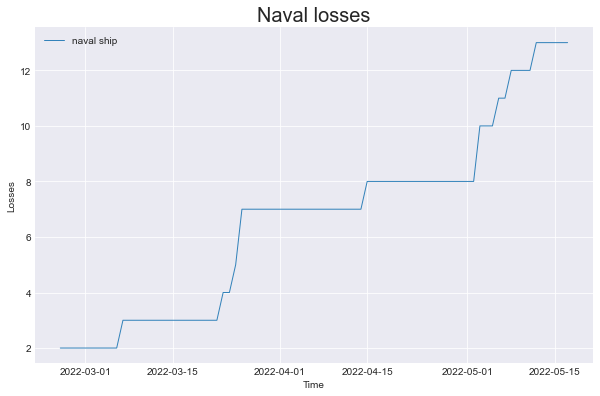

In [16]:
# Plot multiple lines
fig, ax = plt.subplots(figsize= (10,10*0.618))

num=0
for column in df_losses[['naval ship']]:
    num+=1
    plt.plot(df_losses['date'], df_losses[column], marker='', linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Naval losses", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Losses")

# Show the graph
plt.show()

Russian Naval losses happened mostly in late march (most losses were landing ships near Mariupol), with the only loss in April being the sinking of the Moskva Cruiser (14th April), we see Naval losses increasing considerable in May.

___Brief Comparison between Land, Air and Naval losses by absolute numbers <a class="anchor" id="a225"></a>___

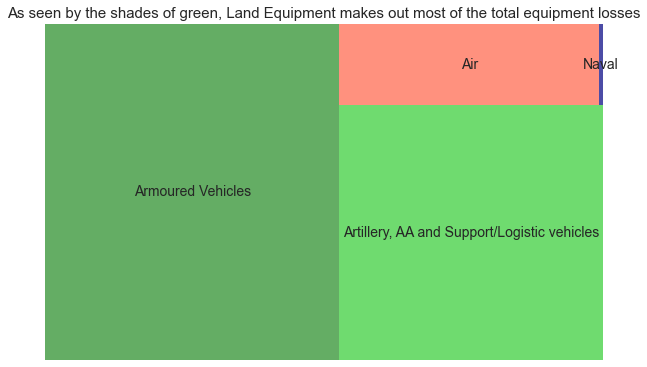

In [17]:
fig, ax = plt.subplots(figsize= (10,10*0.618))

#Getting series for air, land and sea
air_losses = df_losses[['aircraft', 'helicopter', 'drone','cruise missiles']].sum(axis=1)
land_armoured_losses = df_losses[['tank', 'APC']].sum(axis=1)
land_support_losses = df_losses[['field artillery', 'MRL', 'military auto', 'fuel tank','mobile SRBM system', 'vehicles and fuel tanks']].sum(axis=1)
sea_losses = df_losses[['naval ship']].sum(axis=1)

#Getting a dictionary of the last day losses for each of the types above
Casualty_dict = {
'Armoured Vehicles' : land_armoured_losses.tail(1).values,
'Artillery, AA and Support/Logistic vehicles' : land_support_losses.tail(1).values,
'Air' : air_losses.tail(1).values,
'Naval' : sea_losses.tail(1).values}
colors = ['foresTgreen','limegreen','tomato','navy']

Casualty_dict
# preparing a data fram for the treemap
df = pd.DataFrame(Casualty_dict)

# plot it
squarify.plot(sizes = list(Casualty_dict.values()), label = list(Casualty_dict.keys()), color=colors, alpha=.7, text_kwargs={'fontsize':14})
plt.axis('off')
plt.title("As seen by the shades of green, Land Equipment makes out most of the total equipment losses", fontsize=15)
plt.show()

## Correlation Matrix <a class="anchor" id="CM"></a>

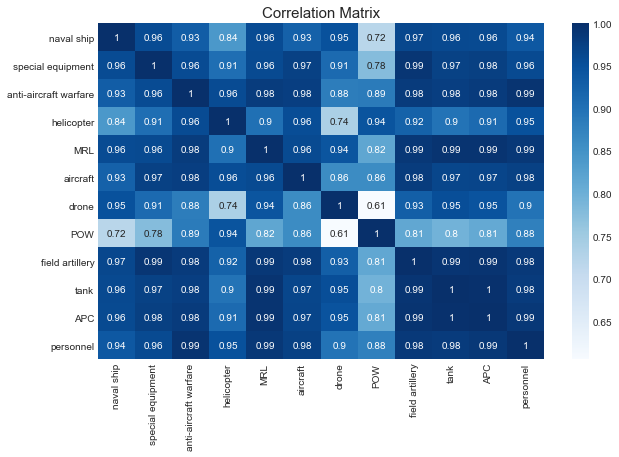

In [18]:
fig, ax = plt.subplots(figsize= (10,10*0.618))

#Our correlation Matrix will include both personnel and equipment, but we must remove variables that are not relevant, we also remove cruise missiles (data available only from may) and 'vehicles and fuel tanks' which is also a recently added category
df_CM = df_losses.loc[:, ~df_losses.columns.isin(['date', 'day', 'week', 'incremental_personnel_loss','military auto', 'fuel tank', 'mobile SRBM system', 'cruise missiles', 'vehicles and fuel tanks'])].sort_values(by=len(df_losses.index)-1, axis=1)


corrMatrix = df_CM.corr()
sns.heatmap(corrMatrix, annot=True, cmap="Blues")

plt.title("Correlation Matrix", fontsize=15)
plt.show()

From all the categories included in the Correlation Matrix, "POW" seems to be the category with the least correlation with others, this may be due to the fact most POWs are from the earliest stages of war, while recently very few new POWs have been made.
Interestingly, if we don't take the POW category into account, drones and Helicopters show the smallest correlation. This goes in line with our assumptions when plotting Air equipment.

# Estimating Future Personnel Losses <a class="anchor" id="ML"></a>

Below we plot an ARIMA model to predict daily Personnel losses for the next 7 day period (18 may to 24 may). 
ARIMA is used in Time Series forecasting, and despite the facts our sample is not even 3 months and a war is an extremely complex phenomenon, we still believe this model will provide an interesting insight for what may come based on prior data.

Text(0.5, 1.0, 'Incremental daily Personnel losses')

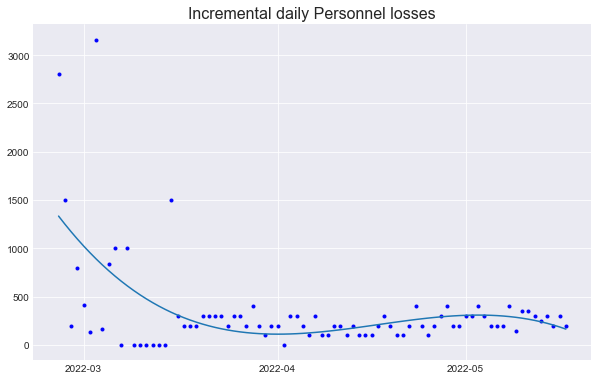

In [19]:
fig, ax = plt.subplots(figsize= (10,10*0.618))

ax.plot(df_losses['date'], df_losses['incremental_personnel_loss'], "b.")

ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[25], interval=1, tz=None))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.grid(True)

    
#adding a trendline to personnel losses
z = np.polyfit(mdates.date2num(df_losses['date']), df_losses['incremental_personnel_loss'], 3)
p = np.poly1d(z)
ax.plot(mdates.date2num(df_losses['date']),p(mdates.date2num(df_losses['date'])))

ax.set_title('Incremental daily Personnel losses', fontsize = 16)

Above we replot the incremental personnel losses graph we've shown in the EDA. Once again, we have a high variance at the start of the period and as the trendline suggests our data does not seem to be linear.

We want to model Incremental daily Personnel losses as time series data, and for that we need it to be stationary, which implies:
1. Constant Mean
2. Constant Variance (which we immediately see is not the case in early weeks)
3. No seasonality 

To test for stationarity we run and ADF (Augmented Dickey Fuller) test:

In [20]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
        
adf_test(df_losses['incremental_personnel_loss'])

1. ADF :  -3.61146684071281
2. P-Value :  0.005545552726518693
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 69
5. Critical Values :
	 1% :  -3.528889992207215
	 5% :  -2.9044395987933362
	 10% :  -2.589655654274312


p< 0.05 so our data is stationary for a significance level of 5%, we are just left to choose the best model possible:

In [21]:
stepwise_fit = auto_arima(df_losses['incremental_personnel_loss'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1226.865, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1272.594, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1247.009, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1226.768, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1270.819, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1227.360, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1227.014, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1226.437, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1227.028, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1226.671, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1245.471, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.711 seconds


The best Arima model for our data is (0, 1, 1). Unfortunately, our AIC score is infinite which is most likely due to our sample size being too small.
Before training our model, we split the data into training and testing. With less than 3 months of data, we'll leave 1 week for testing

In [22]:
print(df_losses.shape)
train=df_losses.iloc[:-7]
test=df_losses.iloc[-7:]
print(train.shape,test.shape)

(82, 21)
(75, 21) (7, 21)


In [23]:
#training our arima model
model=ARIMA(train['incremental_personnel_loss'],order=(0,1,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     incremental_personnel_loss   No. Observations:                   75
Model:                         ARIMA(0, 1, 1)   Log Likelihood                -561.594
Date:                        Tue, 17 May 2022   AIC                           1127.189
Time:                                17:12:02   BIC                           1131.797
Sample:                                     0   HQIC                          1129.027
                                         - 75                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8305      0.061    -13.714      0.000      -0.949      -0.712
sigma2      2.358e+05   2.49e+04      9.452      0.000    1.87e+05    2.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               323.03
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

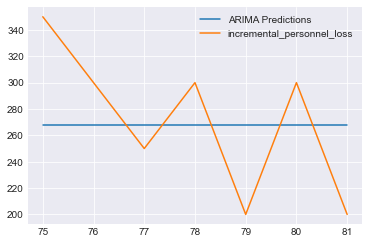

In [24]:
#testing our model
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['incremental_personnel_loss'].plot(legend=True)

Given the nature of our model, which tries to predict daily Russian Personnel Losses in this war (too many variables and extremely hard to predict), our model predictions don't really seem to be too far off.

In [25]:
test['incremental_personnel_loss'].mean()
rmse=sqrt(mean_squared_error(pred,test['incremental_personnel_loss']))
print("rmse:",rmse)

rmse: 52.60906208363841


This high RMSE means we are overfiting the data which means our model can test well in sample but has little predictive value when tested out of sample. An ARIMA (0,1,1) is also a very simplified model (hence the constant prediction for every day). Once again, predicting war losses is not an easy task do with a model, specially given our small sample size.

In [26]:
#Predicting future losses for 17 May to 23 May
index_future_dates = pd.date_range(start='2022-05-18', end='2022-05-24')
print(index_future_dates)
pred2 = model.predict(start=len(df_losses),end=len(df_losses)+6, typ='levels').rename('ARIMA predictions')
print(pred2)
pred2.index = index_future_dates
print(pred2)

DatetimeIndex(['2022-05-18', '2022-05-19', '2022-05-20', '2022-05-21',
               '2022-05-22', '2022-05-23', '2022-05-24'],
              dtype='datetime64[ns]', freq='D')
82    267.877322
83    267.877322
84    267.877322
85    267.877322
86    267.877322
87    267.877322
88    267.877322
Name: ARIMA predictions, dtype: float64
2022-05-18    267.877322
2022-05-19    267.877322
2022-05-20    267.877322
2022-05-21    267.877322
2022-05-22    267.877322
2022-05-23    267.877322
2022-05-24    267.877322
Freq: D, Name: ARIMA predictions, dtype: float64


Text(0.5, 1.0, 'Our model predicts Russia will suffer 268 Incremental daily Personnel losses each day of the upcoming week')

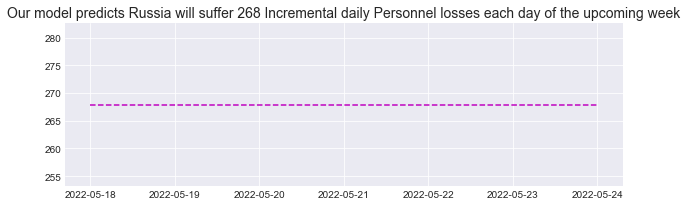

In [27]:
fig, ax = plt.subplots(figsize= (10,3))

ax.plot(pred2,'m--')

ax.set_title(f'Our model predicts Russia will suffer {round(pred2[-1])} Incremental daily Personnel losses each day of the upcoming week', fontsize = 14)